In [22]:
# imports
import logging
import sys
import time
from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh
import matplotlib.pyplot as plt
import asyncio
import datetime
import random
import websockets
import nest_asyncio
import http.server
import socketserver
import threading
from IPython.display import IFrame
import base64
from PIL import Image
from io import BytesIO

nest_asyncio.apply()

logger = logging.getLogger('TfPoseEstimatorRun')
logger.handlers.clear()
logger.setLevel(logging.ERROR)
ch = logging.StreamHandler()
ch.setLevel(logging.ERROR)
formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)


In [2]:
# params
w, h = 0, 0
image_path = './data/images/pose2.jpg'
model = 'cmu'
resize_out_ratio = 8.0

In [ ]:
if w == 0 or h == 0:
    e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
else:
    e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))

In [4]:
# estimate human poses from a single image !
image = common.read_imgfile(image_path, None, None)
if image is None:
    logger.error('Image can not be read, path=%s' % image)
    sys.exit(-1)

t = time.time()
humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
elapsed = time.time() - t

logger.info('inference image: %s in %.4f seconds.' % (image, elapsed))

image_result = TfPoseEstimator.draw_humans(image, humans, imgcopy=True)

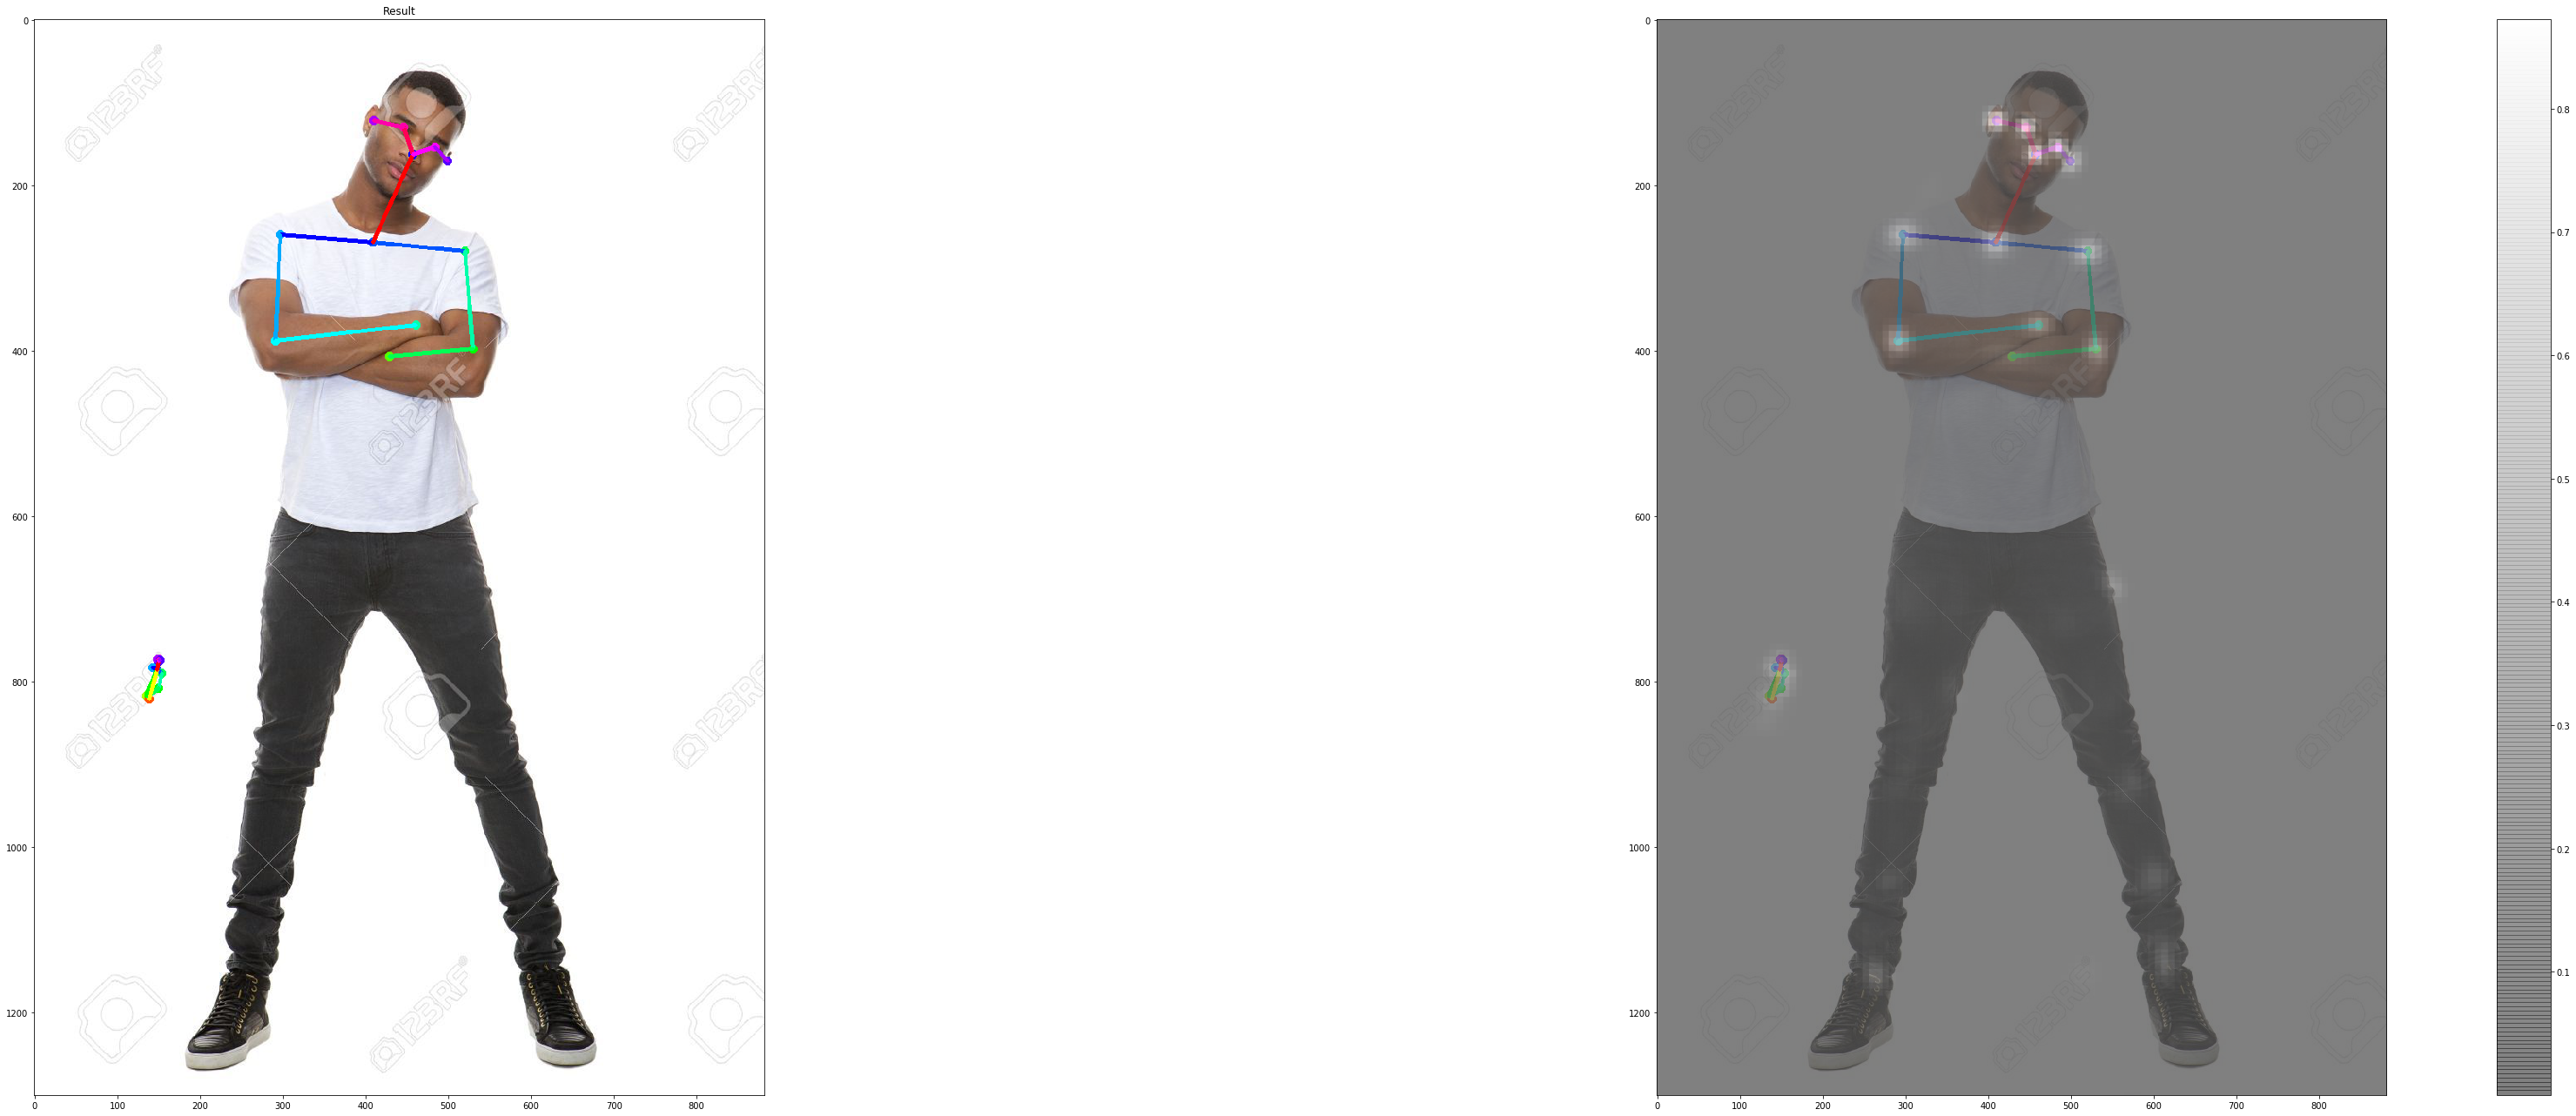

In [5]:
fig = plt.figure(figsize=(100, 50))
a = fig.add_subplot(2, 1, 1)
a.set_title('Result')
plt.imshow(cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB))

bgimg = cv2.cvtColor(image_result.astype(np.uint8), cv2.COLOR_BGR2RGB)
bgimg = cv2.resize(bgimg, (e.heatMat.shape[1], e.heatMat.shape[0]), interpolation=cv2.INTER_AREA)

# show network output
a = fig.add_subplot(2, 2, 2)
plt.imshow(bgimg, alpha=0.5)
tmp = np.amax(e.heatMat[:, :, :-1], axis=2)
plt.imshow(tmp, cmap=plt.cm.gray, alpha=0.5)
_ = plt.colorbar()

In [40]:
def base64_str_2_numpy(b64_image_str):
    buffer = base64.b64decode(b64_image_str) # decode b64 to buffer
    pil_image = Image.open(BytesIO(buffer)) 
    return np.array(pil_image)

def numpy_2_base64(numpy_image):
    res = cv2.cvtColor(numpy_image.astype(np.uint8), cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(res)
    #get image data as byte
    buffer = BytesIO()
    pil_image.save(buffer, format='png')
    buffer_value = buffer.getvalue()

    #byte to string
    return base64.b64encode(buffer_value)

async def websocket_callback(websocket, path):
    while True:
        b64_image_str = await websocket.recv() # read image from websocket
        test_image = base64_str_2_numpy(b64_image_str)
        
        humans = e.inference(test_image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)

        image_result = TfPoseEstimator.draw_humans(test_image, humans, imgcopy=True)
        image_result_b64 = numpy_2_base64(image_result)
        await websocket.send(image_result_b64)

In [37]:
image_mini = Image.open('./data/images/mini.jpg')
print(image_mini.size)

#get image data as byte
buffer = BytesIO()
image_mini.save(buffer, format='png')
buffer_value = buffer.getvalue()

#byte to string
base64_str = base64.b64encode(buffer_value)

#read string to image buffer
buffer2 = base64.b64decode(base64_str)
pil_img2 = Image.open(io.BytesIO(buffer2))
width2, height2 = pil_img2.size

(500, 343)
